# Fastjet with Awkward Arrays
This notebook demonstrates how to use [Fastjet in Python](https://github.com/scikit-hep/fastjet) with Awkward Arrays to cluster jets in particle physics. Using Awkward Arrays allows handling multi-event data and is therefore a fast and efficient way to use Fastjet for large datasets in Python. The [LHC-Olympics data](https://lhco2020.github.io/homepage/) is used for this example. The data consists of dijet events and we want to cluster the events to get the constituents and jet features of the two jets.

## Imports

In [1]:
!pip install fastjet
!pip install tables

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 5.6 MB/s eta 0:00:0000:0100:01m
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.9/398.9 kB 8.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.1/506.1 kB 5.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: blosc2
    Found existing installation: blosc2 2.0.0
    Uninstalling blosc2-2.0.0:
      Successfully uninstalled blosc2-2.0.0


In [1]:
import h5py
import awkward as ak
import energyflow as ef
import fastjet as fj
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import vector
from cycler import cycler

In [3]:
# define plot style
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "#B6BFC3",
        "#3B515B",
        "#0271BB",
        "#E2001A",
    ]
)
mpl.rcParams["font.size"] = 15
mpl.rcParams["patch.linewidth"] = 1.25

## Load Data 
We load the LHC-Olympics data from an h5 file. The data is stored in a pandas dataframe and contains of up to 700 jet constituents per event that are described by the features: $p_T$, $\eta$, $\phi$. The dataset contains 1M QCD dijets background events and 100k W'->XY signal events.

In [71]:
filepath = "/pscratch/sd/d/dimathan/LHCO/events_anomalydetection_v2.h5"

In [72]:
# Load everything into memory
df = pd.read_hdf(filepath)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(1100000, 2101)
Memory in GB: 17.227232456207275


In [73]:
# split data into signal and background
np_array = np.array(df)
background = np_array[np_array[:,2100]==0] 
signal = np_array[np_array[:,2100]==1]

In [74]:
# change the shape of the data to (n_events, n_particles, n_features)
qcd_data = background[:, :2100].reshape(-1, 700, 3)
sig_data = signal[:, :2100].reshape(-1, 700, 3)

In [75]:
# save lengths of signal and background data for later use
len_bckg = len(qcd_data)
len_sig = len(sig_data)
print(f"Background events: {len_bckg}")
print(f"Signal events: {len_sig}")

Background events: 1000000
Signal events: 100000


In [76]:
data_full = np.concatenate((qcd_data, sig_data), axis=0)

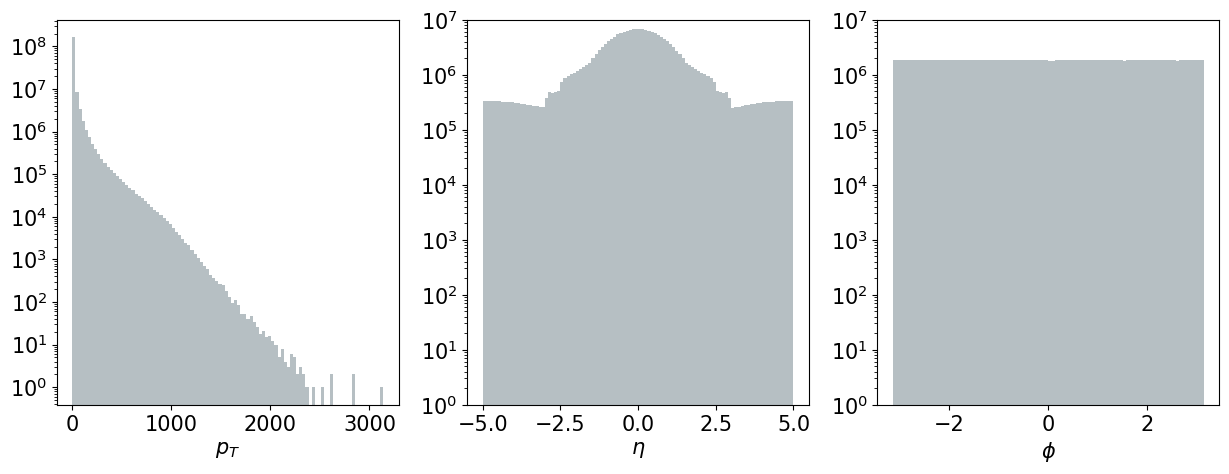

In [77]:
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$"}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index,ax in enumerate(axs):
    ax.hist(
        qcd_data[:, :, index].flatten()[qcd_data[:, :, index].flatten() != 0], bins=100
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    if index == 1:
        ax.set_ylim(1,)
    if index ==2 or index == 1:
        ax.set_ylim(1,1e7)
plt.show()

## Jet Clustering
The jet constituents will be clustered into jets. To allow for an efficient calculation, the data will be stored in awkward arrays. The jet clustering will be done using the [FastJet](http://fastjet.fr/) package. The FastJet package is a C++ library for jet finding. It is interfaced to Python using the [FastJet python](https://pypi.org/project/fastjet/) package.

Awkward arrays are like numpy arrays, but they can have jagged dimensions. This is useful for particle physics, where we have a variable number of particles in each event. To benefit from the speed of awkward, we need to transform our data into an awkward array. For this, we first remove the zero padding and then tell the awkward array that our input data is a 4vector with $p_T$, $\eta$, $\phi$, and $m$.

In [78]:
# to awkard array
zrs = np.zeros((data_full.shape[0], data_full.shape[1], 1))
data_with_mass = np.concatenate((data_full, zrs), axis=2)
awkward_data = ak.from_numpy(data_with_mass)

In [79]:
# tell awkward that the data is in eta, phi, pt, mass format
vector.register_awkward()
unmasked_data = ak.zip({"pt": awkward_data[:,:,0], "eta": awkward_data[:,:,1], "phi": awkward_data[:,:,2], "mass": awkward_data[:,:,3]}, with_name="Momentum4D")
print(unmasked_data.type)

1100000 * 700 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [80]:
# remove the padded data points
data = ak.drop_none(ak.mask(unmasked_data, unmasked_data.pt != 0))
print(data.type)

1100000 * var * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


Now the data can be clustered. For this we have to set the cluster algorithm. In this case, we will use the [Anti-$k_t$ algorithm](https://arxiv.org/abs/0802.1189) with $R=1.0$. 

In [81]:
jetdef = fj.JetDefinition(fj.antikt_algorithm, 1.0)

In [82]:
cluster = fj.ClusterSequence(data, jetdef)

In [83]:
# get jets and constituents
jets_out = cluster.inclusive_jets()
consts_out = cluster.constituents()

## Processing of Data
We want to sort the data and pad it with zeros so that we can transform back to a regular numpy array. A mask is also created to keep track of the padded zeros.

In [84]:
# define a function to sort ak.Array by pt
def sort_by_pt(data: ak.Array, ascending: bool = False, return_indices: bool = False):
    """Sort ak.Array by pt

    Args:
        data (ak.Array): array that should be sorted by pt. It should have a pt attribute.
        ascending (bool, optional): If True, the first value in each sorted group will be smallest; if False, the order is from largest to smallest. Defaults to False.
        return_indices (bool, optional): If True, the indices of the sorted array are returned. Defaults to False.

    Returns:
        ak.Array: sorted array
        ak.Array (optional): indices of the sorted array
    """
    if isinstance(data, ak.Array):
        try:
            temppt = data.pt
        except AttributeError:
            raise AttributeError(
                "Needs either correct coordinates or embedded vector backend"
            ) from None
    tmpsort = ak.argsort(temppt, axis=-1, ascending=ascending)
    if return_indices:
        return data[tmpsort], tmpsort
    else:   
        return data[tmpsort]

In [85]:
# sort jets and constituents by pt
jets_sorted, idxs = sort_by_pt(jets_out, return_indices=True)
consts_sorted_jets = consts_out[idxs]
consts_sorted = sort_by_pt(consts_sorted_jets)

In [86]:
# only take the first 2 highest pt jets
n_jets = 2
jets_awk = jets_sorted[:,:n_jets]
consts_awk = consts_sorted[:,:n_jets]

In [87]:
# get max. number of constituents in an event
max_consts = int(ak.max(ak.num(consts_awk, axis=-1)))
print(max_consts)

279


In [88]:
# pad the data with zeros to make them all the same length
zero_padding = ak.zip({"pt": 0.0, "eta": 0.0, "phi": 0.0, "mass": 0.0}, with_name="Momentum4D")
padded_consts1 = ak.fill_none(ak.pad_none(consts_awk, max_consts, clip=True, axis=-1), zero_padding, axis=-1 )
print(padded_consts1.type)

1100000 * var * 279 * Momentum4D[pt: float64, eta: float64, phi: float64, mass: float64]


In [89]:
# pad the data on the jet axis to make sure to at least have n_jets jets
zero_padding_jet = ak.zip({"pt": [0.0] * max_consts, "eta": [0.0] * max_consts, "phi": [0.0] * max_consts, "mass": [0.0] * max_consts,}, with_name="Momentum4D")
padded_consts = ak.fill_none(ak.pad_none(padded_consts1, n_jets, clip=True, axis=1), zero_padding_jet, axis=1)

In [90]:
# go back to numpy arrays
pt, eta, phi, mass = ak.unzip(padded_consts)
pt_np = ak.to_numpy(pt)
eta_np = ak.to_numpy(eta)
phi_np = ak.to_numpy(phi)
consts = np.stack((pt_np, eta_np, phi_np),axis=-1)
print(consts.shape)

(1100000, 2, 279, 3)


In [91]:
# calculate mask for jet constituents
mask = np.expand_dims((consts[...,0] > 0).astype(int), axis=-1)
print(mask.shape)

(1100000, 2, 279, 1)


In [92]:
# get numpy arrays for jet data
jets_pt_np = ak.to_numpy(jets_awk.pt)
jets_eta_np = ak.to_numpy(jets_awk.eta)
jets_phi_np = ak.to_numpy(jets_awk.phi)
jets_m_np = ak.to_numpy(jets_awk.m)
jets = np.stack((jets_pt_np, jets_eta_np, jets_phi_np, jets_m_np), axis=-1)
print(jets.shape)

(1100000, 2, 4)


Negative jet masses can occur due to jets represented as a single massless particle. We will set the negative masses to zero.

In [93]:
print(np.min(jets[:,:,-1]))
print(np.sum(jets[:,:,-1] < 0))

-4.315837287515549e-05
39


In [94]:
jets[:,:,-1][jets[:,:,-1] < 0] = 0.

In [95]:
print(np.min(jets[:,:,-1]))
print(np.sum(jets[:,:,-1] < 0))

0.0
0


## Save Data
The data will be saved to two h5 files, one for signal and one for background. Both files contain three datasets: jet features, constituents, mask

In [96]:
jets_background = jets[:len_bckg]
jets_signal = jets[len_bckg:]
mask_background = mask[:len_bckg]
mask_signal = mask[len_bckg:]
consts_background = consts[:len_bckg]
consts_signal = consts[len_bckg:]

In [97]:
final_path = "/pscratch/sd/d/dimathan/LHCO/"

In [98]:
background_path = final_path + "processed_data_background.h5"
signal_path = final_path + "processed_data_signal.h5"
with h5py.File(background_path, "w") as f:
    f.create_dataset("jet_data", data=jets_background)
    f.create_dataset("constituents", data=consts_background)  
    f.create_dataset("mask", data=mask_background)  
with h5py.File(signal_path, "w") as f:
    f.create_dataset("jet_data", data=jets_signal)
    f.create_dataset("constituents", data=consts_signal)  
    f.create_dataset("mask", data=mask_signal)  

# Compare to Provided Features
The LHCO dataset provides high-level features for pre-clustered jets. We can compare the features from our clustered jets to the provided data to see how well our clustering algorithm did.

In [99]:
# these will be the x-axis labels for the histograms
label_map = {"0": "$p_T$", "1": "$\eta$", "2": "$\phi$", "3": "$m$"}

## Particle Multiplicity

### Background

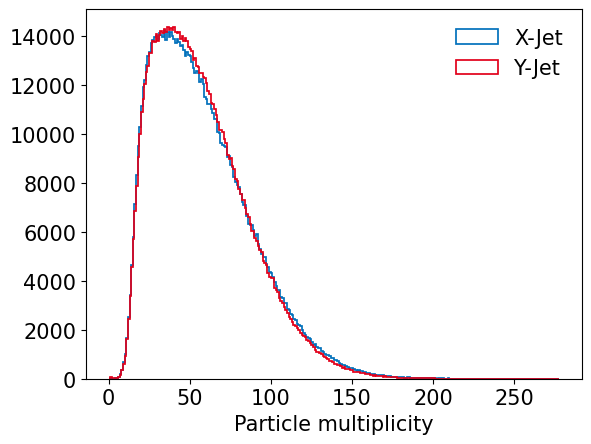

In [100]:
fig, ax = plt.subplots()

# Skip colors in the cycle
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
next_color = color_cycle[2]  # Skip first two colors in the cycle

# Plot the histograms
hist = ax.hist(np.sum(mask_background[:, 0], axis=1).flatten(),
               bins=range(0, max_consts, 1), label="X-Jet", histtype='step', color=color_cycle[2])
ax.hist(np.sum(mask_background[:, 1], axis=1).flatten(),
        bins=range(0, max_consts, 1), label="Y-Jet", histtype='step', color=color_cycle[3])

# Add labels and legend
ax.set_xlabel('Particle multiplicity')
ax.legend(frameon=False)
plt.show()

### Signal

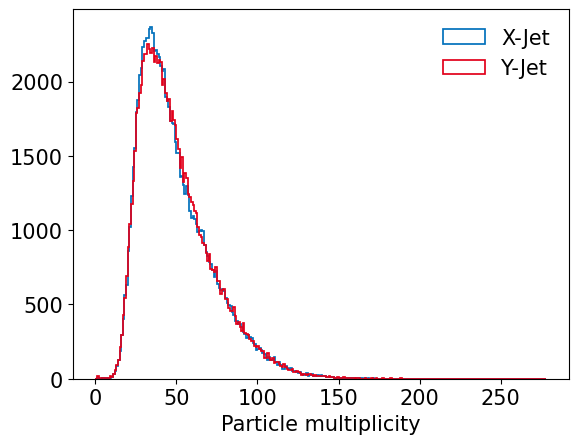

In [101]:
from itertools import cycle
fig, ax = plt.subplots()

# Get the color cycle from Matplotlib's rcParams
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Skip two colors in the cycle
next(color_cycle)  # Skip one
next(color_cycle)  # Skip another

# Plot histograms
hist = ax.hist(
    np.sum(mask_signal[:, 0], axis=1).flatten(),
    bins=range(0, max_consts, 1),
    label="X-Jet",
    histtype="step",
    color=next(color_cycle)  # Use the next color in the cycle
)
ax.hist(
    np.sum(mask_signal[:, 1], axis=1).flatten(),
    bins=hist[1],
    label="Y-Jet",
    histtype="step",
    color=next(color_cycle)  # Use the next color in the cycle
)

# Add labels and legend
ax.set_xlabel("Particle multiplicity")
plt.legend(frameon=False)
plt.show()

## Constituent Features

In [102]:
x_background = consts_background[:,0]
y_background = consts_background[:,1]
x_signal = consts_signal[:,0]
y_signal = consts_signal[:,1]
print(x_background.shape)

(1000000, 279, 3)


### Background

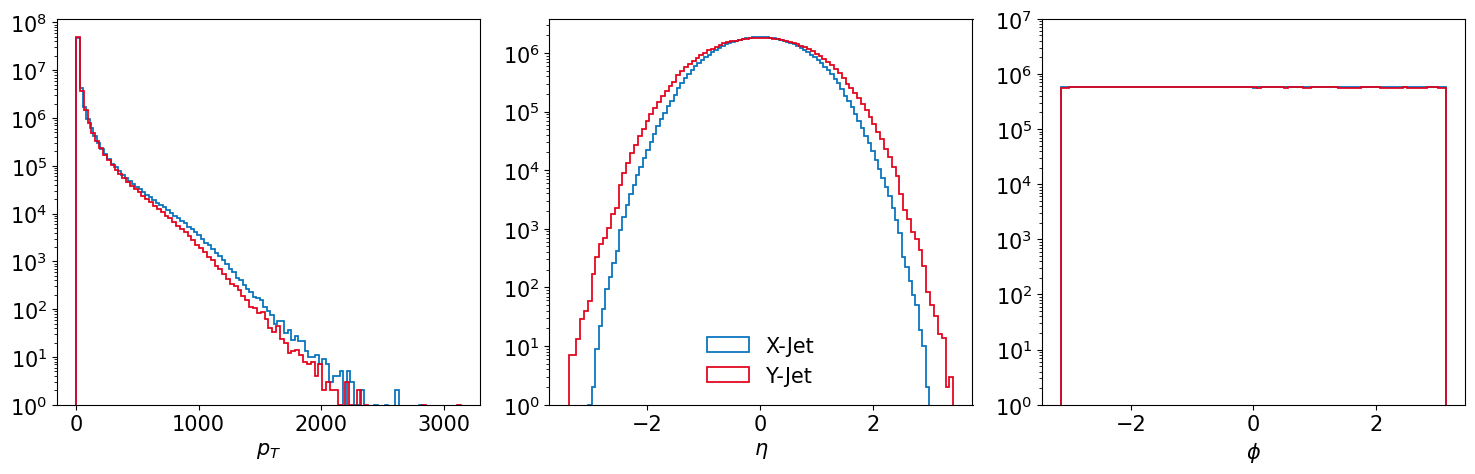

In [103]:
# Define the color cycle explicitly
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index, ax in enumerate(axs):
    # Skip two colors in the cycle for each subplot
    next(color_cycle)  # Skip one
    next(color_cycle)  # Skip another
    
    # Plot histograms for X-Jet and Y-Jet with explicit color assignments
    ax.hist(
        x_background[:, :, index].flatten()[x_background[:, :, index].flatten() != 0],
        bins=100,
        label="X-Jet",
        histtype="step",
        color=next(color_cycle),  # Explicitly use the next color
    )
    ax.hist(
        y_background[:, :, index].flatten()[y_background[:, :, index].flatten() != 0],
        bins=100,
        label="Y-Jet",
        histtype="step",
        color=next(color_cycle),  # Explicitly use the next color
    )
    
    # Set x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")
    
    # Adjust y-scale and limits
    if index in [0, 1, 2]:
        ax.set_yscale("log")
    ax.set_ylim(1,)
    if index == 2:
        ax.set_ylim(1, 1e7)
    
    # Add legend for the second subplot
    if index == 1:
        ax.legend(frameon=False)

# Show the plot
plt.tight_layout()
plt.show()

### Signal

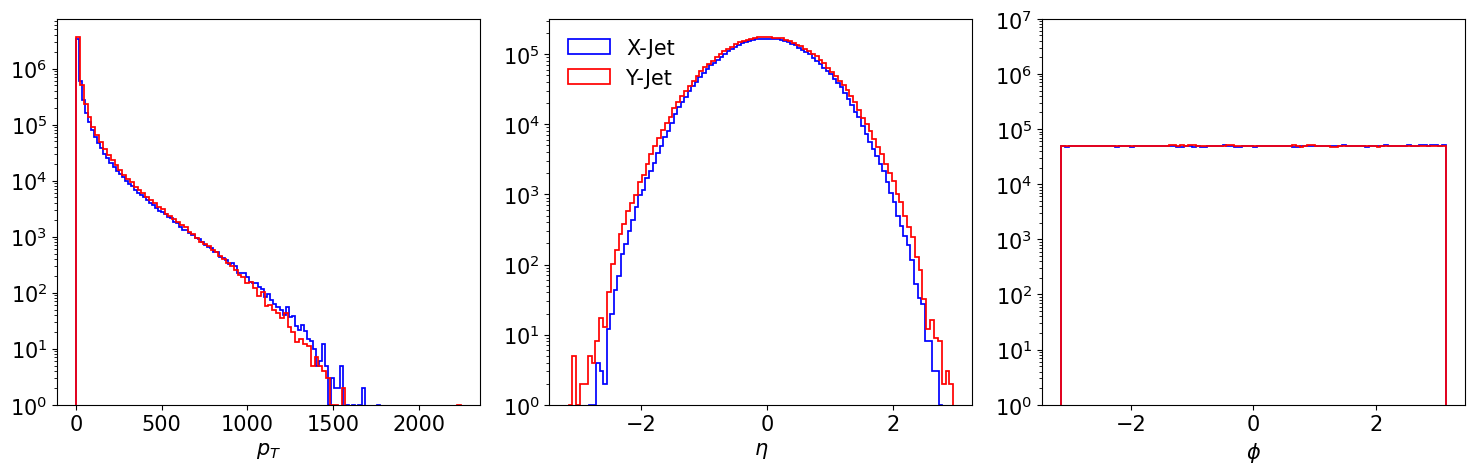

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define color choices
colors = ["blue", "red"]

for index, ax in enumerate(axs):
    # Plot histograms with specific colors
    ax.hist(
        x_signal[:, :, index].flatten()[x_signal[:, :, index].flatten() != 0],
        bins=100,
        label="X-Jet",
        histtype="step",
        color=colors[0],  # Blue for X-Jet
    )
    ax.hist(
        y_signal[:, :, index].flatten()[y_signal[:, :, index].flatten() != 0],
        bins=100,
        label="Y-Jet",
        histtype="step",
        color=colors[1],  # Red for Y-Jet
    )

    # Set axis labels and scale
    ax.set_xlabel(f"{label_map[str(index)]}")
    ax.set_yscale("log")
    ax.set_ylim(1,)

    # Adjust y-limits for specific index
    if index == 2:
        ax.set_ylim(1, 1e7)

    # Add legend for the second plot
    if index == 1:
        ax.legend(frameon=False)

plt.tight_layout()
plt.show()


## Jet Features

### Load and prepare provided features

In [105]:
path_features = "/pscratch/sd/d/dimathan/LHCO/events_anomalydetection_v2.features.h5"

In [106]:
df = pd.read_hdf(path_features)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))


(1100000, 15)
Memory in GB: 0.13113021850585938


In [107]:
feats = np.array(df)
background_feats = feats[feats[...,-1]==0][:,:-1]
signal_feats = feats[feats[...,-1]==1][:,:-1]
print(background_feats.shape)
print(signal_feats.shape)

(1000000, 14)
(100000, 14)


In [108]:
def to_ptyphim(feats):
    """  px, py, pz, mj --> pt, eta, phi, mj"""
    p3 = feats[:, :3]
    e = np.sqrt(feats[:, 0]**2 + feats[:, 1]**2 + feats[:, 2]**2 + feats[:, 3]**2)
    p4 = np.concatenate((e[:, None],p3), axis=1)
    ptyphim = ef.ptyphims_from_p4s(p4, phi_ref=0)
    return ptyphim

In [109]:
feats_x_background = to_ptyphim(background_feats[:,:4])
feats_y_background = to_ptyphim(background_feats[:,7:11])
feats_x_signal = to_ptyphim(signal_feats[:,:4]) 
feats_y_signal = to_ptyphim(signal_feats[:,7:11])

### Prepare fastjet data

In [110]:
jets_x_background = jets_background[:,0]
jets_y_background = jets_background[:,1]
jets_x_signal = jets_signal[:,0]
jets_y_signal = jets_signal[:,1]

alternatively, we can calculate the jet features from the jet constituents directly

In [111]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    return jet_data

In [112]:
jets_x_background_calc = get_jet_data(x_background)
jets_y_background_calc = get_jet_data(y_background)
jets_x_signal_calc = get_jet_data(x_signal)
jets_y_signal_calc = get_jet_data(y_signal)

### Background

#### X-Jet

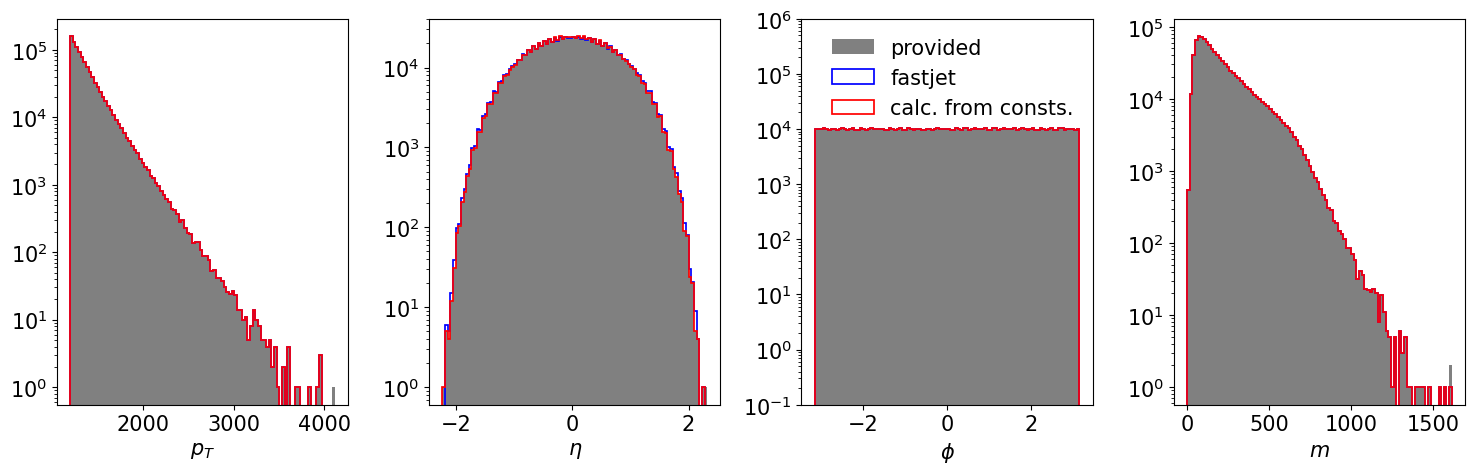

In [123]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Define custom colors for histograms
colors = ["grey", "blue", "red"]

for index, ax in enumerate(axs):
    # Plot "provided" histogram
    hist1 = ax.hist(
        feats_x_background[:, index],
        bins=100,
        label="provided",
        color=colors[0],  # Blue for "provided"
    )

    # Plot "fastjet" histogram
    ax.hist(
        jets_x_background[:, index],
        bins=hist1[1],  # Use the same bin edges as hist1
        histtype="step",
        label="fastjet",
        color=colors[1],  # Orange for "fastjet"
    )

    # Plot "calc. from consts." histogram
    ax.hist(
        jets_x_background_calc[:, index],
        bins=hist1[1],  # Use the same bin edges as hist1
        histtype="step",
        label="calc. from consts.",
        color=colors[2],  # Red for "calc. from consts."
    )

    # Set x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set y-axis to logarithmic scale
    ax.set_yscale("log")

    # Customize y-axis limits for specific indices
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


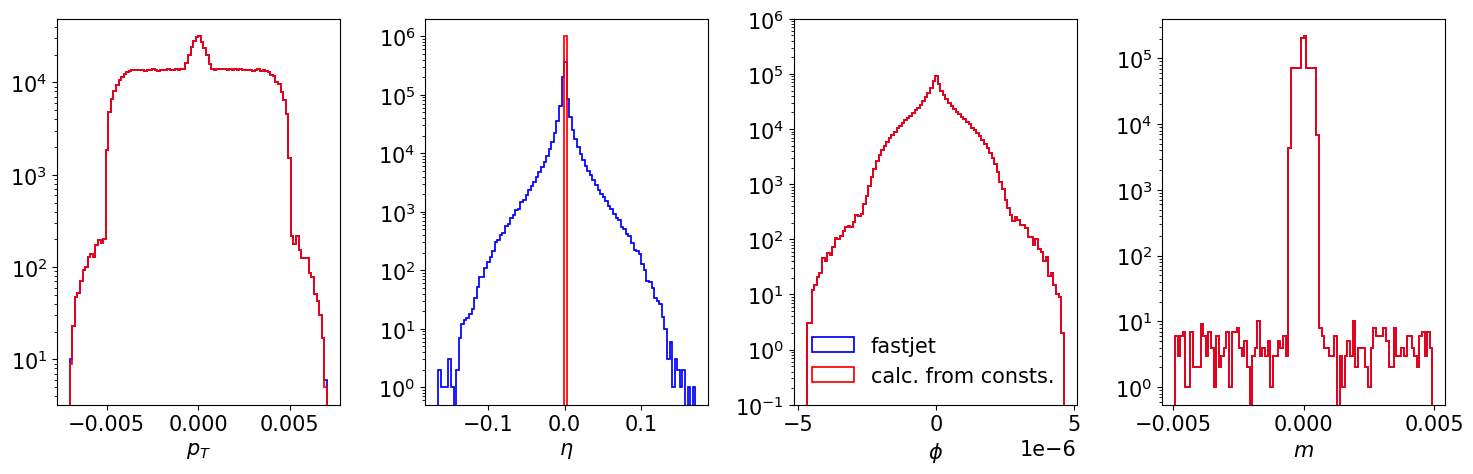

In [126]:
# Assuming `feats_x_background`, `jets_x_background`, and `jets_x_background_calc` are defined
# Define the differences
diff_background_x = feats_x_background - jets_x_background
diff_background_x_calc = feats_x_background - jets_x_background_calc

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Define colors for clarity
colors = ["blue", "red"]

# Loop through each axis and plot
for index, ax in enumerate(axs):
    # Plot "fastjet" difference
    hist1 = ax.hist(
        diff_background_x[:, index],
        bins=100,
        label="fastjet",
        histtype="step",
        color=colors[0],  # Blue for "fastjet"
    )

    # Plot "calc. from consts." difference
    ax.hist(
        diff_background_x_calc[:, index],
        bins=hist1[1],  # Use same bin edges as above
        label="calc. from consts.",
        histtype="step",
        color=colors[1],  # Red for "calc. from consts."
    )

    # Set x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set y-axis to logarithmic scale
    ax.set_yscale("log")

    # Set y-axis limits for specific cases
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


#### Y-Jet

In [ ]:
# Define custom colors
colors = ["grey", "blue", "red"]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for index, ax in enumerate(axs):
    # Plot the "provided" histogram
    hist1 = ax.hist(
        feats_y_background[:, index],
        bins=100,
        label="provided",
        color=colors[0],  # Use the first color
    )

    # Plot the "fastjet" histogram
    ax.hist(
        jets_y_background[:, index],
        bins=hist1[1],  # Use the same bin edges
        histtype="step",
        label="fastjet",
        color=colors[1],  # Use the second color
    )

    # Plot the "calc. from consts." histogram
    ax.hist(
        jets_y_background_calc[:, index],
        bins=hist1[1],  # Use the same bin edges
        histtype="step",
        label="calc. from consts.",
        color=colors[2],  # Use the third color
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set the y-axis scale to logarithmic
    ax.set_yscale("log")

    # Adjust the y-axis limits and add a legend for a specific plot
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


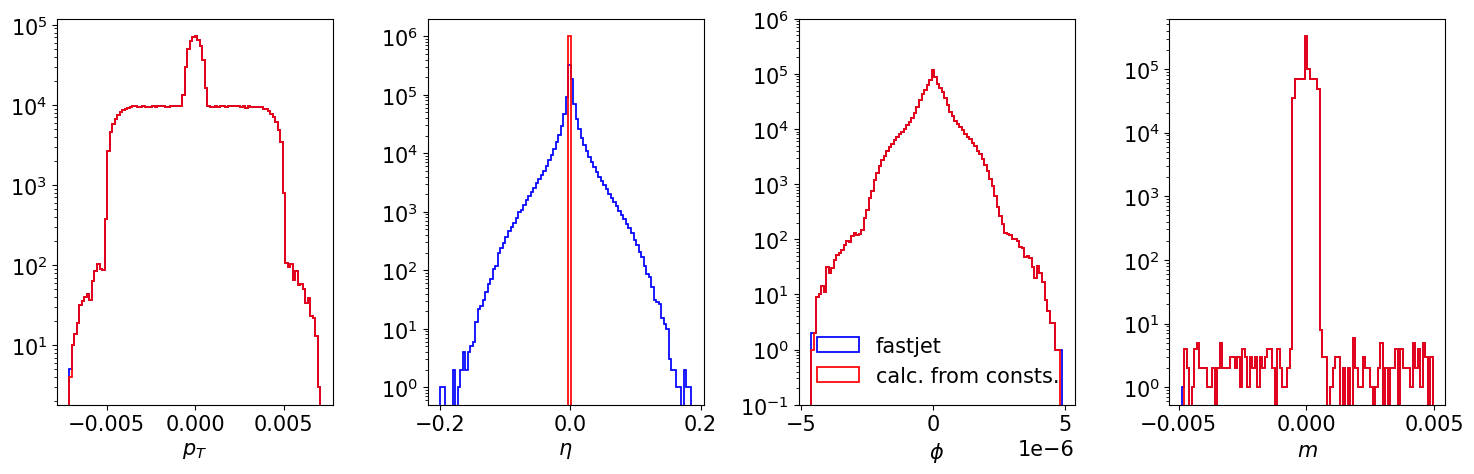

In [131]:
# Define custom colors for clarity
colors = ["blue", "red"]

# Calculate the differences
diff_background_y = feats_y_background - jets_y_background
diff_background_y_calc = feats_y_background - jets_y_background_calc

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for index, ax in enumerate(axs):
    # Plot the "fastjet" histogram
    hist1 = ax.hist(
        diff_background_y[:, index],
        bins=100,
        label="fastjet",
        histtype="step",
        color=colors[0],  # Use blue for "fastjet"
    )

    # Plot the "calc. from consts." histogram
    ax.hist(
        diff_background_y_calc[:, index],
        bins=hist1[1],  # Use the same bin edges
        label="calc. from consts.",
        histtype="step",
        color=colors[1],  # Use red for "calc. from consts."
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set the y-axis to logarithmic scale
    ax.set_yscale("log")

    # Adjust y-axis limits and add legend for a specific plot
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


### Signal

#### X-Jet

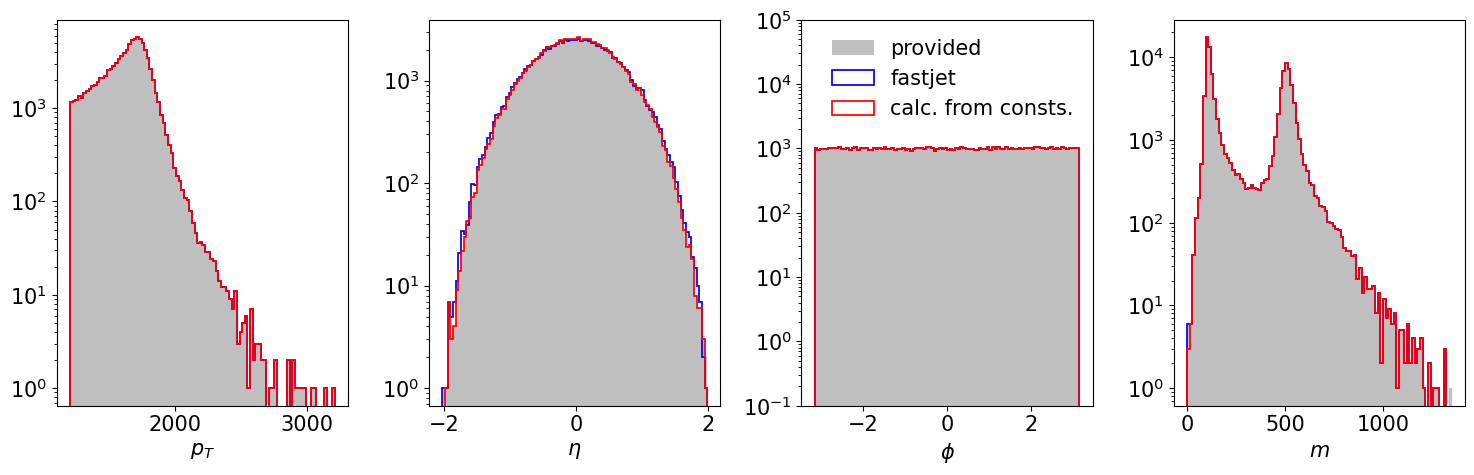

In [134]:
# Define custom colors for clarity
colors = ["gray", "blue", "red"]  # Gray for "provided", blue for "fastjet", red for "calc. from consts."

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for index, ax in enumerate(axs):
    # Plot the "provided" histogram with fill
    hist1 = ax.hist(
        feats_x_signal[:, index],
        bins=100,
        label="provided",
        color=colors[0],  # Use gray for "provided"
        alpha=0.5,        # Add transparency
    )

    # Plot the "fastjet" histogram
    ax.hist(
        jets_x_signal[:, index],
        bins=hist1[1],  # Use the same bin edges
        label="fastjet",
        color=colors[1],  # Use blue for "fastjet"
        histtype="step",
    )

    # Plot the "calc. from consts." histogram
    ax.hist(
        jets_x_signal_calc[:, index],
        bins=hist1[1],  # Use the same bin edges
        label="calc. from consts.",
        color=colors[2],  # Use red for "calc. from consts."
        histtype="step",
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set the y-axis to logarithmic scale
    ax.set_yscale("log")

    # Adjust y-axis limits and add legend for a specific plot
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


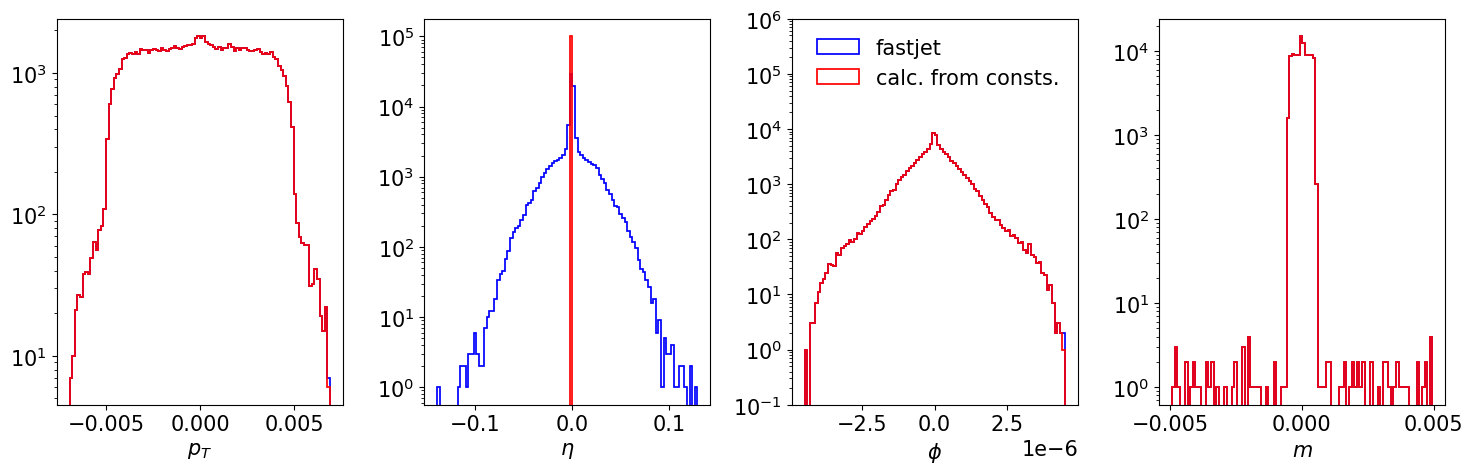

In [144]:
# Calculate the differences
diff_signal_x = feats_x_signal - jets_x_signal
diff_signal_x_calc = feats_x_signal - jets_x_signal_calc

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Define custom colors for clarity
colors = ["blue", "red"]

for index, ax in enumerate(axs):
    # Plot the "fastjet" difference histogram
    hist1 = ax.hist(
        diff_signal_x[:, index],
        bins=100,
        label="fastjet",
        histtype="step",
        color=colors[0],  # Use blue for "fastjet"
    )

    # Plot the "calc. from consts." difference histogram
    ax.hist(
        diff_signal_x_calc[:, index],
        bins=hist1[1],  # Use the same bin edges
        label="calc. from consts.",
        histtype="step",
        color=colors[1],  # Use red for "calc. from consts."
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set the y-axis to logarithmic scale
    ax.set_yscale("log")

    # Adjust y-axis limits and add legend for a specific plot
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


#### Y-Jets

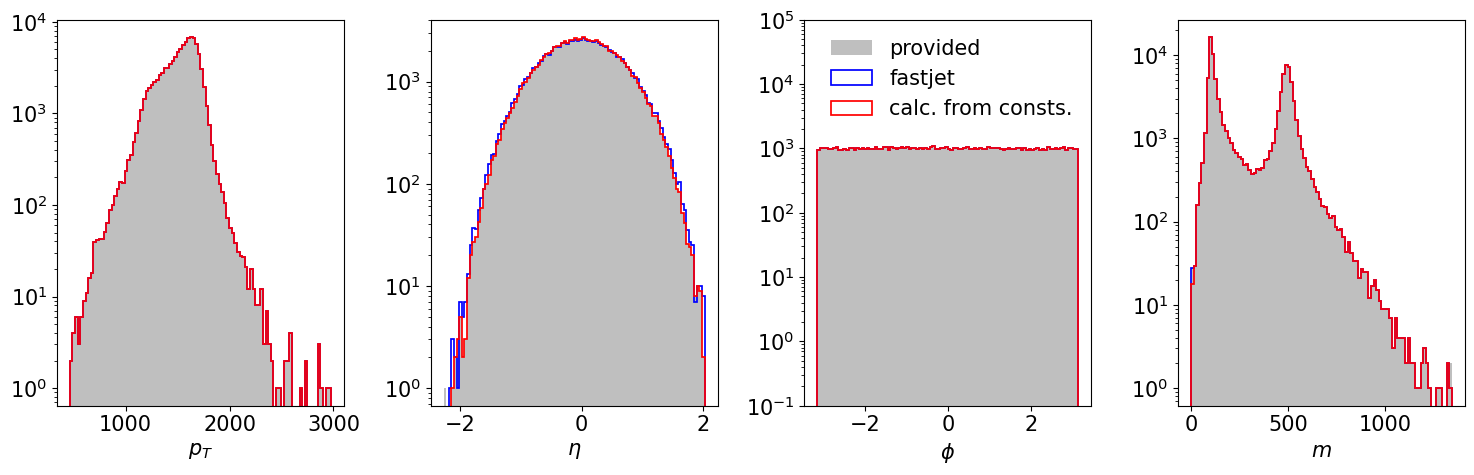

In [145]:
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Define custom colors for clarity
colors = ["gray", "blue", "red"]  # Provided, fastjet, calc. from consts.

for index, ax in enumerate(axs):
    # Plot the "provided" histogram
    hist1 = ax.hist(
        feats_y_signal[:, index],
        bins=100,
        label="provided",
        color=colors[0],  # Use gray for "provided"
        alpha=0.5  # Semi-transparent fill
    )

    # Plot the "fastjet" histogram
    ax.hist(
        jets_y_signal[:, index],
        bins=hist1[1],  # Use the same bin edges
        histtype="step",
        label="fastjet",
        color=colors[1],  # Use blue for "fastjet"
    )

    # Plot the "calc. from consts." histogram
    ax.hist(
        jets_y_signal_calc[:, index],
        bins=hist1[1],  # Use the same bin edges
        histtype="step",
        label="calc. from consts.",
        color=colors[2],  # Use red for "calc. from consts."
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set the y-axis to logarithmic scale
    ax.set_yscale("log")

    # Adjust y-axis limits and add legend for a specific plot
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e5)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


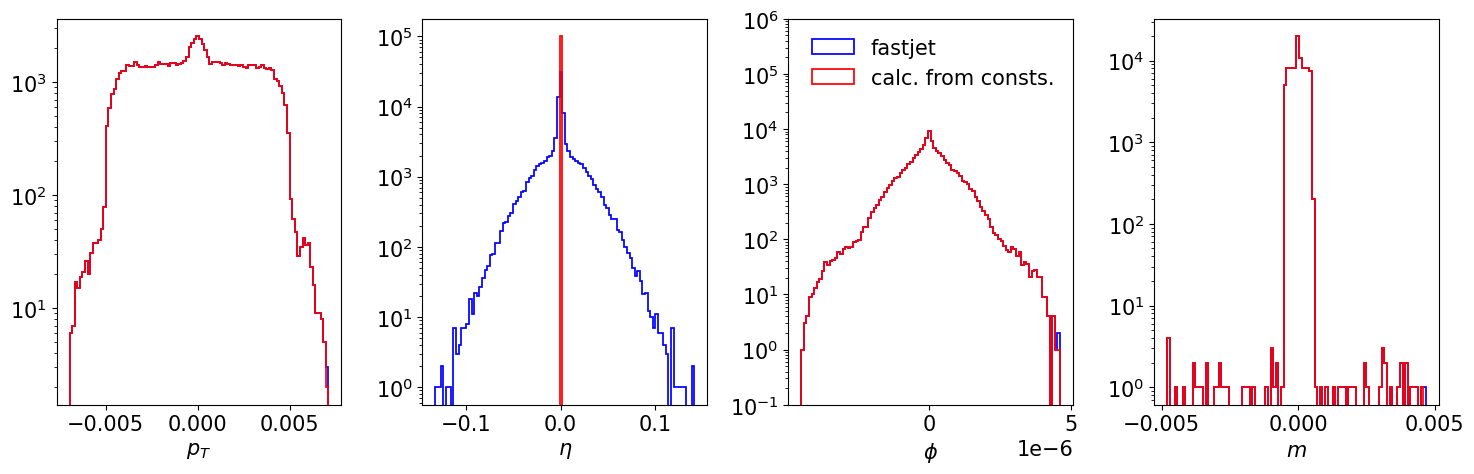

In [147]:
# Calculate the differences
diff_signal_y = feats_y_signal - jets_y_signal
diff_signal_y_calc = feats_y_signal - jets_y_signal_calc

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Define custom colors for clarity
colors = ["blue", "red"]  # Blue for "fastjet", Red for "calc. from consts."

for index, ax in enumerate(axs):
    # Plot the "fastjet" histogram
    hist1 = ax.hist(
        diff_signal_y[:, index],
        bins=100,
        label="fastjet",
        histtype="step",
        color=colors[0],  # Use blue for "fastjet"
    )

    # Plot the "calc. from consts." histogram
    ax.hist(
        diff_signal_y_calc[:, index],
        bins=hist1[1],  # Use the same bin edges
        label="calc. from consts.",
        histtype="step",
        color=colors[1],  # Use red for "calc. from consts."
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map[str(index)]}")

    # Set the y-axis to logarithmic scale
    ax.set_yscale("log")

    # Adjust y-axis limits and add legend for a specific plot
    if index == 2:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Calculate Relative Coordinates
In the following, the coordinates for the constituents will be calculated relative to the jet axis. The relative coordinates are useful because they result in distributions that are easier to model with a neural network. The relative coordinates are defined as follows:
\begin{equation}
    \phi_{rel} = \phi / \phi_{jet}
\end{equation}

\begin{equation}
    \eta_{rel} = \eta - \eta_{jet}
\end{equation}

\begin{equation}
    p_{T,rel} = p_T - p_{T,jet}
\end{equation} 

In [136]:
# calculate jet features
jet_data_calc = get_jet_data(consts)

In [137]:
# calculate relative pt, eta, phi
rel_pt = consts[..., 0] / np.expand_dims(jet_data_calc[..., 0], axis=-1)
rel_eta = consts[..., 1] - np.expand_dims(jet_data_calc[..., 1], axis=-1)
rel_phi = consts[..., 2] - np.expand_dims(jet_data_calc[..., 2], axis=-1)
rel_pt = np.expand_dims(rel_pt, axis=-1)
rel_eta = np.expand_dims(rel_eta, axis=-1)
rel_phi = np.expand_dims(rel_phi, axis=-1)

In [138]:
# wrap phi between -pi and pi
rel_phi = np.where(
    rel_phi > np.pi,
    rel_phi - 2 * np.pi,
    rel_phi,
)
rel_phi = np.where(
    rel_phi < -np.pi,
    rel_phi + 2 * np.pi,
    rel_phi,
)

In [139]:
# fix the masking
rel_phi = rel_phi * mask
rel_eta = rel_eta * mask

In [140]:
consts_rel = np.concatenate((rel_pt, rel_eta, rel_phi), axis=-1)
print(consts_rel.shape)

(1100000, 2, 279, 3)


## Save Data

In [141]:
consts_rel_background = consts_rel[:len_bckg]
consts_rel_signal = consts_rel[len_bckg:]
jets_calc_background = jet_data_calc[:len_bckg]
jets_calc_signal = jet_data_calc[len_bckg:]

In [142]:
final_path_rel = "/pscratch/sd/d/dimathan/LHCO/"

In [143]:
background_path_rel = final_path + "processed_data_background_rel.h5"
signal_path_rel = final_path + "processed_data_signal_rel.h5"
with h5py.File(background_path_rel, "w") as f:
    f.create_dataset("jet_data", data=jets_calc_background)
    f.create_dataset("constituents", data=consts_rel_background)  
    f.create_dataset("mask", data=mask_background)  
with h5py.File(signal_path_rel, "w") as f:
    f.create_dataset("jet_data", data=jets_calc_signal)
    f.create_dataset("constituents", data=consts_rel_signal)  
    f.create_dataset("mask", data=mask_signal)  

## Plots Constituents

In [148]:
# these will be the x-axis labels for the histograms
label_map_rel = {"0": "$p_\mathrm{T}^\mathrm{rel}$", "1": "$\eta^\mathrm{rel}$", "2": "$\phi^\mathrm{rel}$", "3": "$m$"}

In [149]:
consts_rel_background_x = consts_rel_background[:, 0]
consts_rel_background_y = consts_rel_background[:, 1]
consts_rel_signal_x = consts_rel_signal[:, 0]
consts_rel_signal_y = consts_rel_signal[:, 1]

### Background

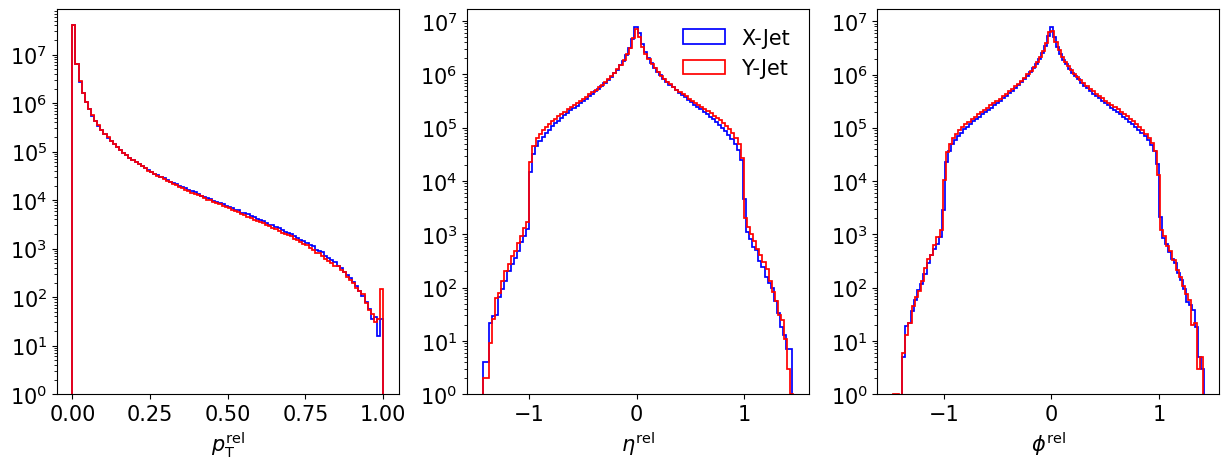

In [151]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for index, ax in enumerate(axs):
    # Plot the "X-Jet" histogram
    ax.hist(
        consts_rel_background_x[..., index].flatten()[consts_rel_background_x[..., index].flatten() != 0],
        bins=100,
        label="X-Jet",
        histtype="step",
        color="blue",  # Use blue for "X-Jet"
    )

    # Plot the "Y-Jet" histogram
    ax.hist(
        consts_rel_background_y[..., index].flatten()[consts_rel_background_y[..., index].flatten() != 0],
        bins=100,
        label="Y-Jet",
        histtype="step",
        color="red",  # Use red for "Y-Jet"
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map_rel[str(index)]}")

    # Set the y-axis to logarithmic scale for specified plots
    if index == 0 or index == 1 or index == 2:
        ax.set_yscale("log")

    # Set y-axis limits
    ax.set_ylim(1,)

    # Add legend for a specific plot
    if index == 1:
        ax.legend(frameon=False)

# Display the plot
plt.show()

### Signal

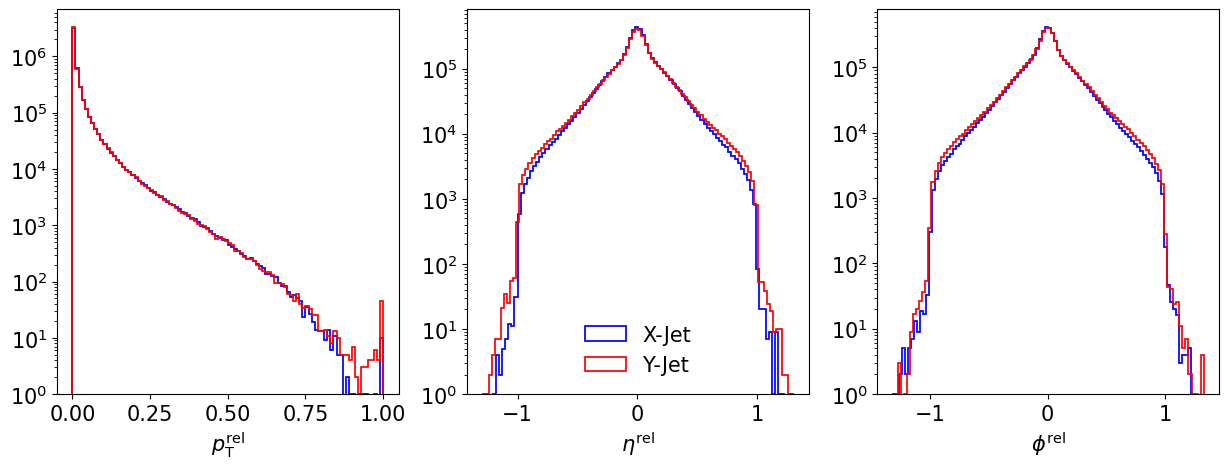

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for X-Jet and Y-Jet for consistent plotting
colors = ["blue", "red"]

for index, ax in enumerate(axs):
    # Plot the "X-Jet" histogram
    ax.hist(
        consts_rel_signal_x[..., index].flatten()[consts_rel_signal_x[..., index].flatten() != 0],
        bins=100,
        label="X-Jet",
        histtype="step",
        color=colors[0],  # Blue for "X-Jet"
    )

    # Plot the "Y-Jet" histogram
    ax.hist(
        consts_rel_signal_y[..., index].flatten()[consts_rel_signal_y[..., index].flatten() != 0],
        bins=100,
        label="Y-Jet",
        histtype="step",
        color=colors[1],  # Red for "Y-Jet"
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map_rel[str(index)]}")

    # Set the y-axis to logarithmic scale for specified plots
    if index in [0, 1, 2]:
        ax.set_yscale("log")

    # Set y-axis limits
    ax.set_ylim(1,)

    # Add legend for a specific plot
    if index == 1:
        ax.legend(frameon=False)

# Display the plot
plt.show()

## Plots Jet
One can also calculate the jet features based on the relative constituents.

In [154]:
jet_data_rel = get_jet_data(consts_rel)
print(jet_data_rel.shape)

(1100000, 2, 4)


In [155]:
jets_rel_background_x = jet_data_rel[:len_bckg, 0]
jets_rel_background_y = jet_data_rel[:len_bckg, 1]
jets_rel_signal_x = jet_data_rel[:len_bckg, 0]
jets_rel_signal_y = jet_data_rel[:len_bckg, 1]

### Background

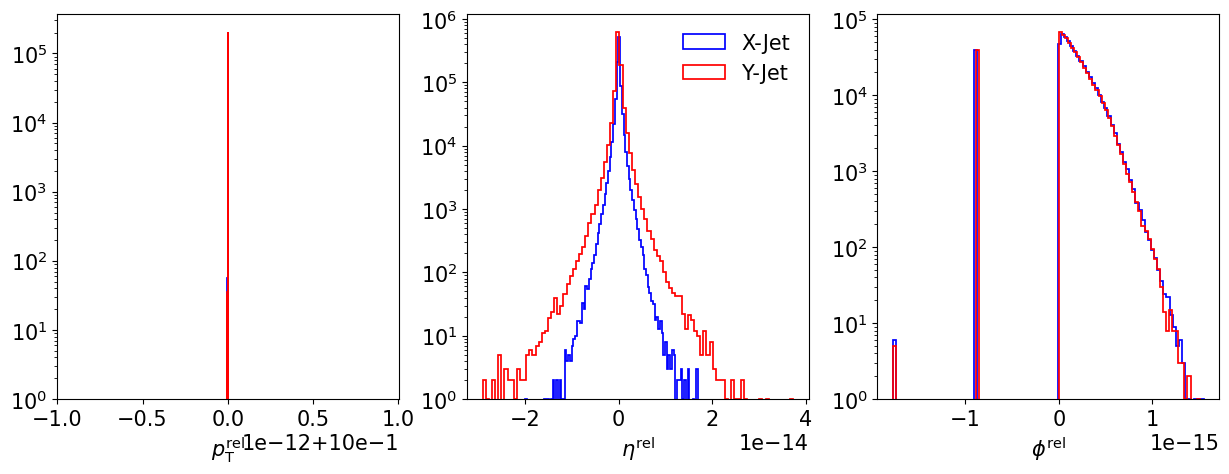

In [157]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for X-Jet and Y-Jet
colors = ["blue", "red"]

for index, ax in enumerate(axs):
    # Plot the "X-Jet" histogram
    ax.hist(
        jets_rel_background_x[..., index].flatten()[jets_rel_background_x[..., index].flatten() != 0],
        bins=100,
        label="X-Jet",
        histtype="step",
        color=colors[0],  # Blue for "X-Jet"
    )

    # Plot the "Y-Jet" histogram
    ax.hist(
        jets_rel_background_y[..., index].flatten()[jets_rel_background_y[..., index].flatten() != 0],
        bins=100,
        label="Y-Jet",
        histtype="step",
        color=colors[1],  # Red for "Y-Jet"
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map_rel[str(index)]}")

    # Set the y-axis to logarithmic scale for specified plots
    if index in [0, 1, 2]:
        ax.set_yscale("log")

    # Set y-axis limits
    ax.set_ylim(1,)

    # Add legend for a specific plot
    if index == 1:
        ax.legend(frameon=False)

# Display the plot
plt.show()

### Signal

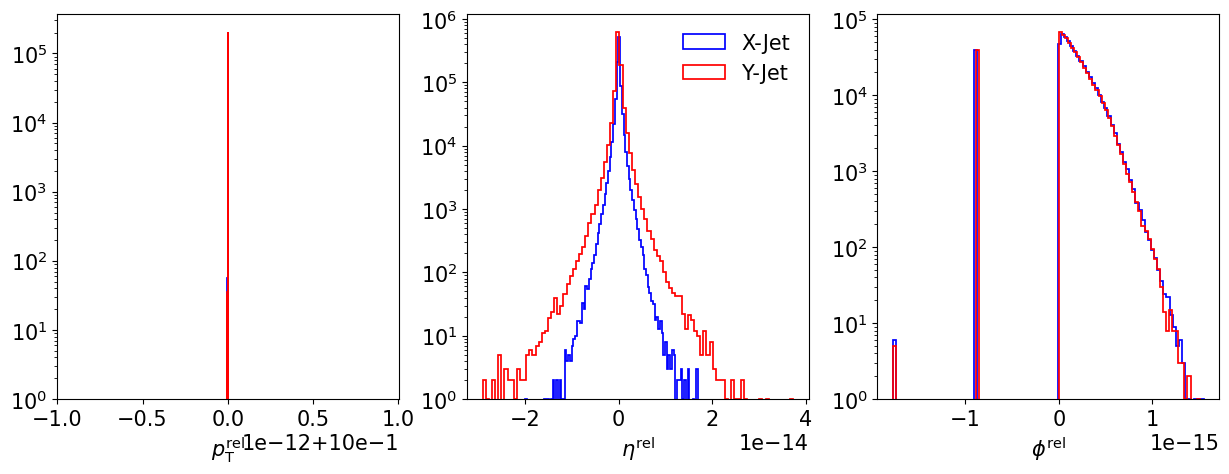

In [158]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colors for the histograms
colors = ["blue", "red"]

for index, ax in enumerate(axs):
    # Plot the "X-Jet" histogram
    ax.hist(
        jets_rel_signal_x[..., index].flatten()[jets_rel_signal_x[..., index].flatten() != 0],
        bins=100,
        label="X-Jet",
        histtype="step",
        color=colors[0],  # Blue for "X-Jet"
    )

    # Plot the "Y-Jet" histogram
    ax.hist(
        jets_rel_signal_y[..., index].flatten()[jets_rel_signal_y[..., index].flatten() != 0],
        bins=100,
        label="Y-Jet",
        histtype="step",
        color=colors[1],  # Red for "Y-Jet"
    )

    # Set the x-axis label
    ax.set_xlabel(f"{label_map_rel[str(index)]}")

    # Set the y-axis to logarithmic scale
    if index in [0, 1, 2]:
        ax.set_yscale("log")

    # Set consistent y-axis limits
    ax.set_ylim(1,)

    # Add a legend for the middle plot
    if index == 1:
        ax.legend(frameon=False)

# Display the plot
plt.show()